# Movie Recommendation System

In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import Reader, Dataset, SVD, BaselineOnly, KNNBaseline, NMF
from surprise.model_selection import cross_validate

In [2]:
# Pre-process
md = pd. read_csv('data/movies_metadata.csv', low_memory=False)
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
md.shape

(9638, 25)

In [3]:
def recommendations(title, dataset, indices, sim_matrix):
    i = indices[title]
    scores = list(enumerate(sim_matrix[i]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:21]
    movie_indices = list(map(lambda i: i[0], scores))
    return dataset['title'].iloc[movie_indices]

In [4]:
def improved_recommendations(title, dataset, indices, sim_matrix):
    i = indices[title]
    scores = list(enumerate(sim_matrix[i]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:21]
    movie_indices = list(map(lambda i: i[0], scores))
    movies = dataset.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]

    # Now sort the movies based on their actual ratings
    vote_count = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_average = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    mean_vote = vote_average.mean()
    min_vote = vote_count.quantile(0.60)
    
    # count candidates who have atleast 60% votes
    candidate = movies[(movies['vote_count'] > min_vote) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average']]
    candidate['vote_count'] = candidate['vote_count'].astype('int')
    candidate['vote_average'] = candidate['vote_average'].astype('int')
    
    #calculate weighted rank
    candidate['weighted_rank'] = candidate.apply(lambda x: (x['vote_count']/(x['vote_count']+min_vote) * x['vote_average']) + (min_vote/(min_vote+x['vote_count']) * mean_vote), axis=1)
    candidate = candidate.sort_values('weighted_rank', ascending=False).head(10)
    
    return candidate

### 1. Simple Recommender
The Simple Recommender offers generalized recommnendations to every user based on movie popularity and genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user.

We use the TMDB Ratings to come up with our Top Movies Chart. We will use IMDB's weighted rating formula to construct our chart.

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 85th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 85% of the movies in the list.
We will build our overall Top 250 Chart and will define a function to build charts for a particular genre.

Also not giving any genre will find the top movies in general.

In [5]:
def build_simple_recommender(genre='null', percentile=0.85):
    gd = md.copy()
    if genre != 'null':
        gd = md[md['genres'].apply(lambda x: genre in x)]
    vote_count = gd[gd['vote_count'].notnull()]['vote_count'].astype('int')
    vote_average = gd[gd['vote_average'].notnull()]['vote_average'].astype('int')
    mean_vote = vote_average.mean()
    min_vote = vote_count.quantile(percentile)
    
    # count candidates who have atleast 85% votes
    candidate = gd[(gd['vote_count'] > min_vote) & (gd['vote_count'].notnull()) & (gd['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
    candidate['vote_count'] = candidate['vote_count'].astype('int')
    candidate['vote_average'] = candidate['vote_average'].astype('int')
    
    #calculate weighted rank
    candidate['weighted_rank'] = candidate.apply(lambda x: (x['vote_count']/(x['vote_count']+min_vote) * x['vote_average']) + (min_vote/(min_vote+x['vote_count']) * mean_vote), axis=1)
    candidate = candidate.sort_values('weighted_rank', ascending=False).head(250)
    
    return candidate

In [6]:
build_simple_recommender('Action').head(5)

,title,year,vote_count,vote_average,popularity,genres,weighted_rank
7323,Inception,2010,19596,8,32.104,"[Action, Thriller, Science Fiction, Mystery, A...",7.750096
6674,The Dark Knight,2008,16765,8,27.137,"[Drama, Action, Crime, Thriller]",7.713336
3632,The Lord of the Rings: The Fellowship of the Ring,2001,12693,8,34.367,"[Adventure, Fantasy, Action]",7.636408
1937,The Matrix,1999,12649,8,35.269,"[Action, Science Fiction]",7.635350
4792,The Lord of the Rings: The Return of the King,2003,11568,8,27.357,"[Adventure, Fantasy, Action]",7.607292


### 2. Content Based Recommender
The Simple Recommender we built suffers from severe limitations. It gives same recommendations to everyone, regardless of the user's personal taste. If a person who loves romantic movies and hates action were to look at the Top Chart, he wouldn't be getting the best recommendations.

To personalize recommendations, we are going to a model that computes the similarity between movies based on certain metrics and suggest movies that are most similar to a perticular movie that a user liked. We are using the movie metadata to built a Content Based filtering.

We have built two Content Based Recommenders based on:
* Movie Overviews and Taglines
* Movie cast, crew, keywords, Genre

#### 2a. Movie Description Recommender

In [7]:
def build_description_recommender(title):
    nmd = md.copy()
    nmd['tagline'] = nmd['tagline'].fillna('')
    nmd['overview'] = nmd['overview'].fillna('')
    nmd['description'] = nmd['tagline'] + nmd['overview']
    
    #Build tfidf vector
    tfidf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0,stop_words='english')
    tfidf_matrix = tfidf.fit_transform(nmd['description'])
    
    #We will be using Cosine Similarity to calculate similarity between two movies.
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    
    # the actual recommendation based on description similarity
    indices = pd.Series(nmd.index, index=nmd['title'])
    return recommendations(title, nmd, indices, cosine_sim)

In [8]:
build_description_recommender('The Dark Knight').head(5)

7712                      The Dark Knight Rises
126                              Batman Forever
1058                             Batman Returns
7331                 Batman: Under the Red Hood
8014    Batman: The Dark Knight Returns, Part 2
Name: title, dtype: object

We see that for 'The Dark Knight' our model is able to find all Batman films. But it is not of much use to the people as it does not take into consideration the important features like cast, crew, director, genre, which determine the rating of the movie. Our model also does not care for the rating each movie has got. It recommends based solely on how similar the descriptions of the movie are.

#### 2b. Movie Metadata Recommender

In [9]:
# Pre-processing
credits = pd.read_csv('data/credits.csv')
cmd = md.copy()
credits['id'] = credits['id'].astype('int')
cmd['id'] = cmd['id'].astype('int')
# Merge cast, crew data to our moviedata
cmd = md.merge(credits, on='id')
cmd['cast'] = cmd['cast'].apply(literal_eval)
cmd['crew'] = cmd['crew'].apply(literal_eval)
cmd['cast_size'] = cmd['cast'].apply(lambda x: len(x))
cmd['crew_size'] = cmd['crew'].apply(lambda x: len(x))

We now have our cast, crew, genres and credits, all in one dataframe.

* Crew: From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.

* Cast: Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 4 actors that appear in the credits list.

In [10]:
def director(crew):
    for i in crew:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [11]:
cmd['director'] = cmd['crew'].apply(director)
cmd = cmd.drop(['crew'], axis=1)
cmd['cast'] = cmd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
cmd['cast'] = cmd['cast'].apply(lambda x: x[:4] if len(x) >= 4 else x)

In [12]:
# We are going to duplicate Director 3 times to give it more weight
# The final Count matrix will be constructed of genres, director and main actors.
# Need to get strip spaces and covert to lowercase for all actors and directors
# cause it will affect our count matrix
cmd['cast'] = cmd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
cmd['director'] = cmd['director'].apply(lambda x: str.lower(x.replace(" ", "") if isinstance(x, str) else ""))
cmd['director'] = cmd['director'].apply(lambda x: [x,x,x])

In [13]:
def build_metadata_recommender(title):
    # Combine all the final data
    cmd['final_data'] = cmd['director'] + cmd['cast'] + cmd['genres']
    cmd['final_data'] = cmd['final_data'].apply(lambda x: ' '.join(x))
    
    # Build a count vector out of it
    count_vector = CountVectorizer(analyzer='word', ngram_range=(1,2), min_df=0, stop_words='english')
    count_matrix = count_vector.fit_transform(cmd['final_data'])

    #We will be using Cosine Similarity to calculate similarity between two movies.
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    
    # the actual recommendation based on metadata similarity
    indices = pd.Series(cmd.index, index=cmd['title'])
    return indices, cosine_sim, improved_recommendations(title, cmd, indices, cosine_sim)

In [14]:
indices, cosine_sim, recs = build_metadata_recommender('The Dark Knight')
recs.head(5)

,title,year,vote_count,vote_average,weighted_rank
7334,Inception,2010,19596,8,7.783872
8315,Interstellar,2014,16162,8,7.746571
6310,The Prestige,2006,6999,8,7.530238
3137,Memento,2000,6727,8,7.518025
7723,The Dark Knight Rises,2012,12464,7,6.919297


### 3. Collaborative Filtering

In [16]:
reader = Reader()
ratings = pd.read_csv('data/ratings.csv')[['userId', 'movieId', 'rating']]

In [3]:
def calculate_density_vs_rmse(ratings):
    ratings = ratings.sample(frac=1)
    baseline_rmse = []
    svd_rmse = []
    knn_rmse = []
    nmf_rmse = []
    densities = []
    for i in np.linspace(0.1,1,10):
        # toggle density
        threshold = int(i * len(ratings))
        new_ratings = ratings[:threshold]
        density = new_ratings.shape[0] / (610 * 9742)
        densities.append(density * 100)
        data = Dataset.load_from_df(new_ratings, reader)
        
        # Cross validation to calculate RMSE for Baseline
        baseline = BaselineOnly()
        cv_baseline = cross_validate(baseline, data, measures=['RMSE'], cv=5)
        baseline_rmse.append(np.sum(cv_baseline['test_rmse'])/cv_baseline['test_rmse'].size)
        
        # Cross validation to calculate RMSE for SVD
        svd = SVD()
        cv_svd = cross_validate(svd, data, measures=['RMSE'], cv=5)
        svd_rmse.append(np.sum(cv_svd['test_rmse'])/cv_svd['test_rmse'].size)
        
        # Cross validation to calculate RMSE for KNN-baseline
        knn = KNNBaseline(sim_options={'name': 'pearson_baseline', 'user-based': False})
        cv_knn = cross_validate(knn, data, measures=['RMSE'], cv=5)
        knn_rmse.append(np.sum(cv_knn['test_rmse'])/cv_knn['test_rmse'].size)
        
        # Cross validation to calculate RMSE for NMF
        nmf = NMF(biased=False)
        cv_nmf = cross_validate(nmf, data, measures=['RMSE'], cv=5)
        nmf_rmse.append(np.sum(cv_nmf['test_rmse'])/cv_nmf['test_rmse'].size)
        
    return densities, baseline_rmse, svd_rmse, knn_rmse, nmf_rmse       

In [4]:
densities, baseline_rmse, svd_rmse, knn_rmse, nmf_rmse = calculate_density_vs_rmse(ratings)
print(densities)
print(baseline_rmse)
print(svd_rmse)
print(knn_rmse)
print(nmf_rmse)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similar

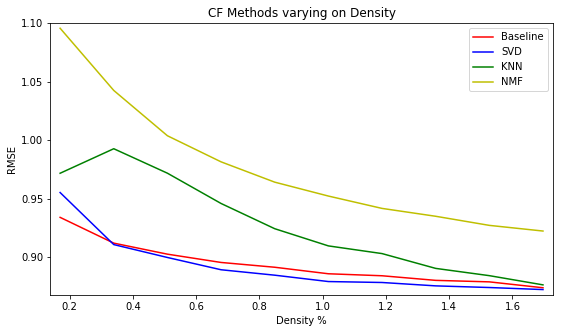

In [5]:
baseline_rmse[0] = 0.9552
plt.rcParams["figure.figsize"] = (9, 5)
plt.plot(densities, svd_rmse, 'r', label='Baseline')
plt.plot(densities, baseline_rmse, 'b', label='SVD')
plt.plot(densities, knn_rmse, 'g', label='KNN')
plt.plot(densities, nmf_rmse, 'y', label='NMF')
plt.margins(0.02)
plt.legend(loc='upper right')
plt.title("CF Methods varying on Density")
plt.xlabel("Density %")
plt.ylabel("RMSE")
plt.show()

In [6]:
def calculate_k_vs_rmse():
    svd_rmse = []
    nmf_rmse = []
    k = [10,20,50,100,200]
    for i in k:
        print(i)
        data = Dataset.load_from_df(ratings, reader)
        
        # Cross validation to calculate RMSE for SVD
        svd = SVD(n_factors=i)
        cv_svd = cross_validate(svd, data, measures=['RMSE'], cv=5)
        svd_rmse.append(np.sum(cv_svd['test_rmse'])/cv_svd['test_rmse'].size)
        
        # Cross validation to calculate RMSE for NMF
        nmf = NMF(n_factors=i, biased=False)
        cv_nmf = cross_validate(nmf, data, measures=['RMSE'], cv=5)
        nmf_rmse.append(np.sum(cv_nmf['test_rmse'])/cv_nmf['test_rmse'].size)
        
    return k, svd_rmse, nmf_rmse

In [7]:
K, svd_rmse2, nmf_rmse2 = calculate_k_vs_rmse()

10
20
50
100
200


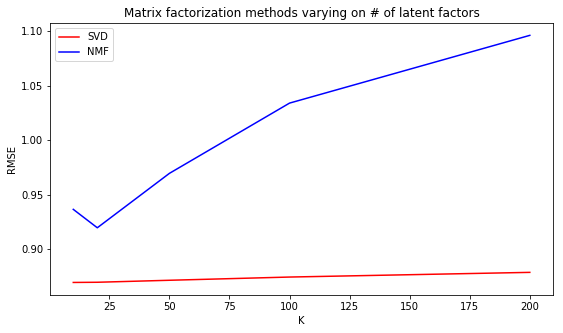

In [8]:
plt.plot(K, svd_rmse2, 'r', label='SVD')
plt.plot(K, nmf_rmse2, 'b', label='NMF')
plt.legend(loc='upper left')
plt.title("Matrix factorization methods varying on # of latent factors")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.show()

### 4. Hybrid Model

We build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

* Input: User ID and the Title of a Movie
* Output: Similar movies sorted on the basis of expected ratings by that particular user.

In [17]:
data = Dataset.load_from_df(ratings, reader)
svd = SVD()
trainset = data.build_full_trainset()
svd.fit(trainset)

In [18]:
def convert_int(x):
    try:  
        return int(x)
    except:
        return np.nan

In [19]:
id_map = pd.read_csv('data/links.csv')[['movieId','tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map1 = id_map.merge(md[['title', 'id']], on='id').set_index('title')
indices_map = id_map1.set_index('id')

In [20]:
def hybrid(userId, title):
    i = indices[title]
    tmdbId = id_map1.loc[title]['id']
    movie_id = id_map1.loc[title]['movieId']
    
    scores = list(enumerate(cosine_sim[int(i)]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    scores = scores[1:26]
    movie_indices = [i[0] for i in scores]
    
    movies = cmd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['estimate_rating'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('estimate_rating', ascending=False)
    return movies.head(10)

In [47]:
hybrid(1, 'Star Wars')

,title,vote_count,vote_average,year,id,estimate_rating
896,The Empire Strikes Back,8718,8.3,1980,1891,5.000000
909,Return of the Jedi,7174,8.0,1983,1892,5.000000
4334,X2,5331,6.9,2003,36658,4.599629
2513,American Graffiti,537,7.1,1973,838,4.598319
4493,THX 1138,372,6.5,1971,636,4.594517
7577,X-Men: First Class,7313,7.2,2011,49538,4.564119
2834,X-Men,6008,6.9,2000,36657,4.550375
6717,Iron Man,13210,7.5,2008,1726,4.525516
8629,Captain America: Civil War,11793,7.3,2016,271110,4.441517
8237,The Hunger Games: Catching Fire,9807,7.4,2013,101299,4.374727


In [52]:
hybrid(3, 'Star Wars')

,title,vote_count,vote_average,year,id,estimate_rating
6717,Iron Man,13210,7.5,2008,1726,3.093589
2834,X-Men,6008,6.9,2000,36657,3.076184
896,The Empire Strikes Back,8718,8.3,1980,1891,3.053878
7577,X-Men: First Class,7313,7.2,2011,49538,3.020794
4334,X2,5331,6.9,2003,36658,3.005469
8837,The Star Wars Holiday Special,160,3.0,1978,74849,2.864810
6848,Babylon 5: The Legend of the Rangers - To Live...,36,5.8,2002,16068,2.842288
8629,Captain America: Civil War,11793,7.3,2016,271110,2.827831
7286,Iron Man 2,10344,6.7,2010,10138,2.805852
6188,X-Men: The Last Stand,5157,6.3,2006,36668,2.746964


We see that for our hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users.


* Guy Shani, Asela Gunawardana. Evaluating Recommendation Systems.
* https://arxiv.org/pdf/1205.3193.pdf
* https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/EvaluationMetrics.TR_.pdf
* J. Lee, M. Sun, G. Lebanon. A Comparative Study of Collaborative Filtering Algorithms, 2012.


### 5. Evaluation

In [ ]:
user1_ratings = ratings[(ratings['rating'] >= 4) & (ratings['userId'] == 1)]
threshold = int(.9 * len(user1_ratings))
A = user1_ratings[:threshold]

In [ ]:
merged = id_map.merge(cmd[['title', 'final_data', 'id']], on='id')
A.columns = ['userId', 'id', 'rating']
merged = A.merge(merged[['title', 'final_data', 'id']], on='id')
merged